In [1]:
import keras
from keras import metrics
import tensorflow as tf
from keras import losses
import numpy as np
from keras import layers
from keras import optimizers
from keras.datasets import mnist

In [2]:

# Custom VAE class

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# Dimensionality of sampled latent vector.
latent_dim = 10

In [5]:
# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 90,177
Trainable params: 90,177
Non-trainable params: 0
_______________________________________________________

In [10]:
# Training the model

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

# Scaling all Images
mnist_digits = mnist_digits/255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(),metrics=["accuracy"])

vae.fit(mnist_digits, epochs=50, batch_size=64)

Epoch 1/50
1094/1094 [==============================] - 14s 11ms/step - loss: 123.6725 - reconstruction_loss: 112.6627 - kl_loss: 10.9126
Epoch 2/50
1094/1094 [==============================] - 12s 11ms/step - loss: 123.3523 - reconstruction_loss: 112.5946 - kl_loss: 10.9357
Epoch 3/50
1094/1094 [==============================] - 12s 11ms/step - loss: 123.4912 - reconstruction_loss: 112.5944 - kl_loss: 10.9382
Epoch 4/50
1094/1094 [==============================] - 12s 11ms/step - loss: 123.5501 - reconstruction_loss: 112.5609 - kl_loss: 10.9227
Epoch 5/50
1094/1094 [==============================] - 12s 11ms/step - loss: 123.3762 - reconstruction_loss: 112.5898 - kl_loss: 10.9365
Epoch 6/50
1094/1094 [==============================] - 12s 11ms/step - loss: 123.3582 - reconstruction_loss: 112.5472 - kl_loss: 10.9306
Epoch 7/50
1094/1094 [==============================] - 12s 11ms/step - loss: 123.0956 - reconstruction_loss: 112.5308 - kl_loss: 10.9491
Epoch 8/50
1094/1094 [============

Z_SAMPLE Image0: [[ 1.37869284 -0.11089521 -0.53548469 -0.509772    0.59865037 -0.47166224
  -1.53476227 -2.08934117 -1.15543114  1.25526464]]
Z_SAMPLE Image1: [[ 1.54893734  0.51603095 -0.22455499  0.15716096  0.42236286 -0.49387841
  -0.45078638 -0.27606909 -0.76892264 -1.18803506]]
Z_SAMPLE Image2: [[ 1.08582131 -0.07646912  0.73347728 -0.66599971 -0.92634687 -0.27888803
   0.30908643  1.27981737  0.60768279  0.99227538]]
Z_SAMPLE Image3: [[-0.87983676 -1.50469187  0.99643155 -1.03760607 -0.63504809  0.3670902
  -1.94208009 -3.2045307  -1.63362186 -0.63112397]]
Z_SAMPLE Image4: [[ 1.54436678  1.47294978 -0.60511314  1.14383859  0.62995055  1.3181023
  -0.30538598 -0.47045344  0.387667    0.60878063]]
Z_SAMPLE Image5: [[-0.36311868  0.35864749 -0.11468259 -1.10757676  0.96025095 -0.46193701
  -0.38255939 -0.65659867 -0.70746079  0.53717772]]
Z_SAMPLE Image6: [[ 2.06686722 -1.27073446  1.67105775 -0.10784616  0.80473743  1.70209957
  -0.57878567  0.19135544  0.95831693 -2.43867655]]
Z

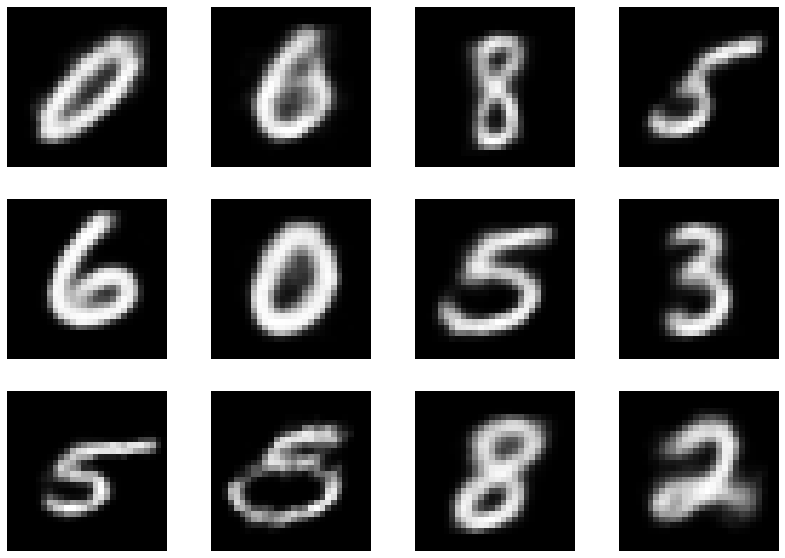

In [18]:
# Generating new Images using the Decoder as a standalone model.

import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
for i in range(12):
    # creating list of random numbers from Std Normal distribution.
    # list will have same length as latent_dim
    random_nums = np.random.normal(loc=0, scale=1, size=latent_dim)

    z_sample = np.array([random_nums])
    print("Z_SAMPLE Image{}: {}".format(i,z_sample))
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(28, 28)
    
    plt.subplot(3,4,i+1)
    plt.axis("off")
    plt.imshow(digit, cmap="gray")

plt.show()

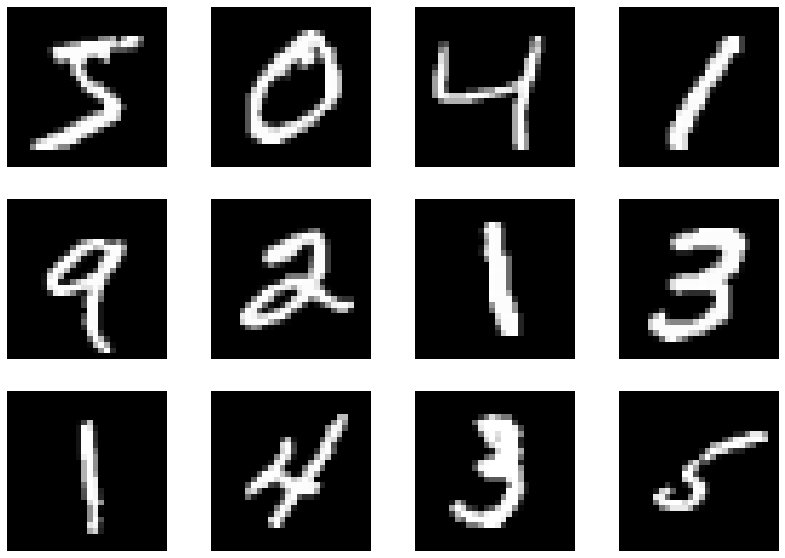

In [12]:
# Plotting images from training dataset to compare.

plt.figure(figsize=(14,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.axis("off")
    plt.imshow(x_train[i], cmap="gray")
plt.show()